In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.8

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
from jax import random
from scipy.linalg import circulant
from jax import grad, jit, vmap, value_and_grad
import optax
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp

def getStepDataSimple(angles,thres=0):
    X=np.block([[np.cos(angles)],[np.sin(angles)]]).T
    Y=(np.sin(angles)>=thres)[:,None]*2.0 - 1
    return X,Y

def loadData(dataName,N,P,seed=0,zeromean=False):
    np.random.seed(seed)

    All=True
    if dataName=='MNIST':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,All=All)
    if dataName=='Fashion':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,All=All,home=home)
    if dataName=='CIFAR':
        grayscale=False
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    if dataName=='CIFARG':
        grayscale=True
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    if dataName=='Circulant':
        angles=np.linspace(0,2*np.pi,N)
        X,Y=getStepDataSimple(angles,thres=0)
    
    X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

    train_idx=np.random.choice(np.arange(N),P,replace=False)

    train_ID=np.ones(N)==0
    train_ID[train_idx]=True
    test_ID=np.invert(train_ID)

    x_train=X[train_ID,:]
    x_test=X[test_ID,:]

    if zeromean:
        Y=Y-np.mean(Y)
        
    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    
    return X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID

def accuracy(y_pred,y):
    return jnp.mean(y_pred == y)
def getNN(yr_test,y_class):
    pdist=pairwise_distances(yr_test, y_class, metric='euclidean')
    tp_test=jnp.argmin(pdist,axis=1)
    return y_class[tp_test,:],tp_test
def getMax(yr_test):
    tp_test=jnp.argmax(yr_test,axis=1)
    return tp_test


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.8


In [31]:
from scipy.optimize import fsolve
import scipy as sp

def getkfunc(s0,eta,P):
    def func_root(ka):
        return s0 + np.sum((ka*eta)/(ka+P*eta)) - ka
    return func_root

def getgam(eta,P,ka):
    return np.sum(P*np.square(eta)/np.square(ka+P*eta))
###

def kappa_fn(kappa, *args):
    (p, lamb, spectrum, degens) = args
    return kappa - lamb - kappa * np.sum(spectrum*degens/(p*spectrum + kappa))

def kappa_fn_derivative(kappa, *args):
    (p, lamb, spectrum, degens) = args
    return 1 - np.sum(spectrum*degens/(p*spectrum + kappa)) + kappa*np.sum(spectrum*degens/(p*spectrum + kappa)**2)

def solve_kappa(p, lamb, spectrum, degens = []):
    if len(degens) == 0:
        degens = np.ones(len(spectrum))
    
    args = (p, lamb, spectrum, degens)
    return sp.optimize.root_scalar(kappa_fn, x0 = p*np.amax(spectrum), args = args, 
                                   fprime = kappa_fn_derivative, method = 'newton').root

def gamma_fn(p, kappa, spectrum, degens = []):
    if len(degens) == 0:
        degens = np.ones(len(spectrum))
        
    return p * degens * spectrum**2 / (kappa + spectrum*p)**2
###

def arccos_runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,s0=0,sep=False,x_test=0,y_test=0,prepend='arccos',append=''):
    resolution=100000#100000000
    trapz_n=10000
    chunk_size=100000
    
    Ls=jnp.arange(2,20)
    sigmabs=jnp.linspace(0,0.01,10)
    m=0
    tau=1e-5
    errAf=np.zeros((jnp.shape(sigmabs)[0],jnp.shape(Ls)[0]))
    accAf=np.copy(errAf)
    for j, sigmab in enumerate(sigmabs):
        sigma=1
        converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)

        if sep:
            load_names_tr=gp.getarccos_fast_and_save(x_train,x_train,converter,sigma=sigma,sigmab=sigmab,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getarccos_fast_and_save(x_train,x_test,converter,sigma=sigma,sigmab=sigmab,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')            
        else:
            load_names_tr=gp.getarccos_fast_and_save(x_train,x_train,converter,sigma=sigma,sigmab=sigmab,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getarccos_fast_and_save(x_train,X,converter,sigma=sigma,sigmab=sigmab,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        
        for g, L in enumerate(Ls):
        #try:
            if dotheory:
                K=np.load(load_names_te[g])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]                
            else:
                K=0
                A=np.load(load_names_tr[g])
                C=np.load(load_names_te[g])


            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)
            
            if sep:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-y_test))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(y_test))
            else:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, m:{}, L:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),m,L))

        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    theory_or_not='exp_'

    #filename='gb_comp_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    filename=prepend+theory_or_not+dataName+'_P{}_N{}_s0{}_sigb{}'.format(P,N,s0,sigmab) + append
    np.savez('./sweep_data/'+filename,P=P,N=N,s0=s0,Ls=Ls,errAf=errAf,accAf=accAf,seed=seed)



MNIST
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:2.23e-02, sigma:1.00, pa:5.00e-01

err:2.01e-02, sigma:1.00, pa:5.00e-01, m:0, L:4, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:5, 
err:1.98e-02, sigma:1.00, pa:5.00e-01, m:0, L:6, 
err:1.98e-02, sigma:1.00, pa:5.00e-01, m:0, L:7, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:8, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:9, 
err:2.00e-02, sigma:1.00, pa:5.00e-01, m:0, L:10, 
err:2.00e-02, sigma:1.00, pa:5.00e-01, m:0, L:11, 
err:2.01e-02, sigma:1.00, pa:5.00e-01, m:0, L:12, 
err:2.06e-02, sigma:1.00, pa:5.00e-01, m:0, L:13, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:14, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:15, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:16, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:17, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:18, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:2.23e-02, sigma:1.00, pa:5.00e-01, m:0, L:2, 
err:2.07e-02, sigma:1.00, pa:5.00e-01, m:0, L:3, 
err:2.02e-02, sigma:1.00, pa:5.00e-01, m:0, L:4, 
err:2.00e-02, sigma:1.00, pa:5.00e-01, m:0, L:5, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:6, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:7, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:8, 
err:1.99e-02, sigma:1.00, pa:5.00e-01, m:0, L:9, 
err:2.00e-02, sigma:1.00, pa:5.00e-01, m:0, L:10, 
err:2.16e-02, sigma:1.00, pa:5.00e-01, m:0, L:11, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:12, 
err:nan, sigma:1.00, pa:5

err:nan, sigma:1.00, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.26e-01, sigma:1.00, pa:5.00e-01, m:0, L:2, 
err:1.10e-01, sigma:1.00, pa:5.

err:nan, sigma:1.00, pa:5.00e-01, m:0, L:10, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:11, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:12, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:13, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:14, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:15, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:16, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:17, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:18, 
err:nan, sigma:1.00, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4t

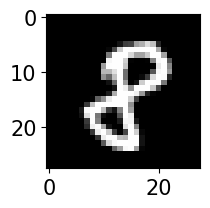

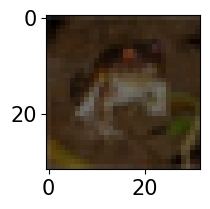

In [32]:
## derived from "Comparison to the google brain result"

dotheory=False
zeromean=False
m=0
s0=0

dataNames=['MNIST','CIFAR']
#dataNames=['CIFAR','CIFARG']

Ps=np.array([1000])

seeds=[0]
for seed in seeds:
    for dataName in dataNames:
        print(dataName)
        for i,P in enumerate(Ps):
            #seed=0
            N=int(10000+P)
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            arccos_runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,
                     s0=0,sep=True,x_test=x_test,y_test=y_test,append='_seed'+str(seed))

            

(0.2, 0.4)

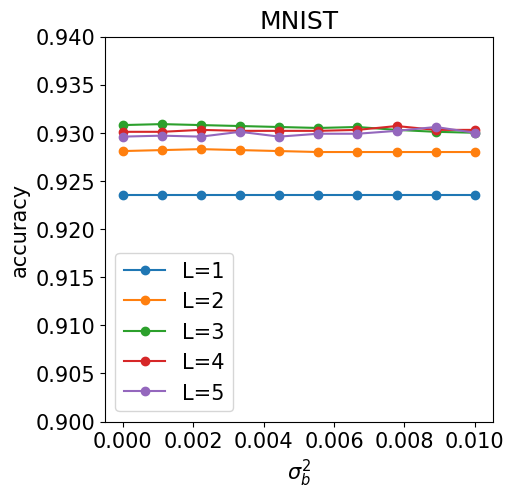

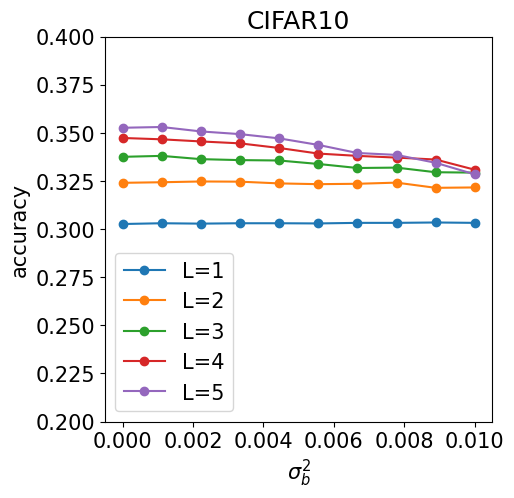

In [78]:
sigmabs=jnp.linspace(0,0.01,10)
#filename='exp_'+dataName+'_P{}_N{}_m{}.npz'.format(P,N,m)
#filename='arccosexp_CIFAR_P1000_N11000_s00_sigb0.009999999776482582_seed0.npz'
filename='arccosexp_MNIST_P1000_N11000_s00_sigb0.009999999776482582_seed0.npz'
#filename='exp_'+dataName+'_P{}_N{}_m{}_s0{}.npz'.format(P,N,m,s0)
st=np.load('./sweep_data/'+filename)
errAf=st['errAf']
accAf=st['accAf']


Ls=st['Ls']
minid=np.argmin(errAf,axis=0)
minerr=errAf[minid,np.arange(np.shape(Ls)[0])]
glomin=np.unravel_index(errAf.argmin(), errAf.shape)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(sigmabs,accAf[:,0],'o-',label='L=1')
ax.plot(sigmabs,accAf[:,1],'o-',label='L=2')
ax.plot(sigmabs,accAf[:,2],'o-',label='L=3')
ax.plot(sigmabs,accAf[:,3],'o-',label='L=4')
ax.plot(sigmabs,accAf[:,4],'o-',label='L=5')

ax.set_xlabel(r'$\sigma^2_b$')
ax.set_ylabel('accuracy')
ax.set_title('MNIST')
ax.legend()

ax.set_ylim([0.9,0.94])

#filename='exp_'+dataName+'_P{}_N{}_m{}.npz'.format(P,N,m)
filename='arccosexp_CIFAR_P1000_N11000_s00_sigb0.009999999776482582_seed0.npz'
#filename='arccosexp_MNIST_P1000_N11000_s00_sigb0.009999999776482582_seed0.npz'
#filename='exp_'+dataName+'_P{}_N{}_m{}_s0{}.npz'.format(P,N,m,s0)
st=np.load('./sweep_data/'+filename)
errAf=st['errAf']
accAf=st['accAf']


Ls=st['Ls']
minid=np.argmin(errAf,axis=0)
minerr=errAf[minid,np.arange(np.shape(Ls)[0])]
glomin=np.unravel_index(errAf.argmin(), errAf.shape)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(sigmabs,accAf[:,0],'o-',label='L=1')
ax.plot(sigmabs,accAf[:,1],'o-',label='L=2')
ax.plot(sigmabs,accAf[:,2],'o-',label='L=3')
ax.plot(sigmabs,accAf[:,3],'o-',label='L=4')
ax.plot(sigmabs,accAf[:,4],'o-',label='L=5')

ax.set_xlabel(r'$\sigma^2_b$')
ax.set_ylabel('accuracy')
ax.set_title('CIFAR10')
ax.legend()

ax.set_ylim([0.2,0.4])


#im=ax.pcolor(st['Ls']-1,sigmabs,errAf,cmap='jet',vmax=0.045,vmin=0.005)
